# Analytical spectra

In [8]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

from pyleoclim import spectral
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
def run_wwz(series, xlim=[0, 0.05], label='WWZ', loglog=False, title=None, detrend=False):
    time = series.index.values
    signal = series.values
    tau = np.linspace(np.min(time), np.max(time), 51)
    res_psd = spectral.wwz_psd(signal, time, tau=tau, standardize=False, detrend=detrend)
    
    sns.set(style='ticks', font_scale=1.5)
    fig = plt.figure(figsize=[10, 10])                                                                                                                                           
    ax_signal = plt.subplot(2, 1, 1)
    ax_signal.plot(time, signal, label='signal')                                                                                                                                                          
    ax_signal.spines['right'].set_visible(False)
    ax_signal.spines['top'].set_visible(False)
    ax_signal.set_ylabel('Value')
    ax_signal.set_xlabel('Time')
    if title:
        ax_signal.set_title(title)
    
    ax_spec = plt.subplot(2, 1, 2)
    if loglog:
        ax_spec.loglog(res_psd.freq, res_psd.psd, lw=3, label=label)                                                                                                                                                          
    else:
        ax_spec.plot(res_psd.freq, res_psd.psd, lw=3, label=label)                                                                                                                                                          
        ax_spec.set_xlim(xlim)
        
    ax_spec.get_xaxis().set_major_formatter(ScalarFormatter())
    ax_spec.xaxis.set_major_formatter(FormatStrFormatter('%g'))
    ax_spec.set_ylabel('Spectral Density')                                                                                                                                                 
    ax_spec.set_xlabel('Frequency')                                                                                                                                                   
    ax_spec.legend(frameon=False)
    ax_spec.spines['right'].set_visible(False)
    ax_spec.spines['top'].set_visible(False)
    
    return fig, res_psd, ax_spec

In [124]:
def run_ls(series, xlim=[0, 0.05], label='Lomb-Scargle', loglog=False, title=None, detrend=False,standardize=False):
    time = series.index.values
    signal = series.values
    tau = np.linspace(np.min(time), np.max(time), 51)
    res_psd = spectral.lomb_scargle(signal, time, standardize=standardize, detrend=detrend,n50=3)
    print(res_psd)
    sns.set(style='ticks', font_scale=1.5)
    fig = plt.figure(figsize=[10, 10])                                                                                                                                           
    ax_signal = plt.subplot(2, 1, 1)
    ax_signal.plot(time, signal, label='signal')                                                                                                                                            
    ax_signal.spines['right'].set_visible(False)
    ax_signal.spines['top'].set_visible(False)
    ax_signal.set_ylabel('Value')
    ax_signal.set_xlabel('Time')
    if title:
        ax_signal.set_title(title)
    
    ax_spec = plt.subplot(2, 1, 2)
    if loglog:
        ax_spec.loglog(res_psd['freq'], res_psd['psd'], lw=3, label=label)                                                                                                                                                          
    else:
        ax_spec.plot(res_psd['freq'], res_psd['psd'], lw=3, label=label)                                                                                                                                                          
        ax_spec.set_xlim(xlim)
        
    ax_spec.get_xaxis().set_major_formatter(ScalarFormatter())
    ax_spec.xaxis.set_major_formatter(FormatStrFormatter('%g'))
    ax_spec.set_ylabel('Spectral Density')                                                                                                                                                 
    ax_spec.set_xlabel('Frequency')                                                                                                                                                   
    ax_spec.legend(frameon=False)
    ax_spec.spines['right'].set_visible(False)
    ax_spec.spines['top'].set_visible(False)
    
    return fig, res_psd, ax_spec
    
    
    
    

In [111]:
def colored_noise(alpha, t, f0=None, m=None, seed=None):
    ''' Generate a colored noise timeseries
    Args:
        alpha (float): exponent of the 1/f^alpha noise
        t (float): time vector of the generated noise
        f0 (float): fundamental frequency
        m (int): maximum number of the waves, which determines the
            highest frequency of the components in the synthetic noise
    Returns:
        y (array): the generated 1/f^alpha noise
    References:
        Eq. (15) in Kirchner, J. W. Aliasing in 1/f(alpha) noise spectra: origins, consequences, and remedies.
            Phys Rev E Stat Nonlin Soft Matter Phys 71, 066110 (2005).
    '''
    n = np.size(t)  # number of time points
    y = np.zeros(n)

    if f0 is None:
        f0 = 1/n  # fundamental frequency
    if m is None:
        m = n//2

    k = np.arange(m) + 1  # wave numbers

    if seed is not None:
        np.random.seed(seed)

    theta = np.random.rand(int(m))*2*np.pi  # random phase
    for j in range(n):
        coeff = (k*f0)**(-alpha/2)
        sin_func = np.sin(2*np.pi*k*f0*t[j] + theta)
        y[j] = np.sum(coeff*sin_func)

    return y

def colored_noise_2regimes(alpha1, alpha2, f_break, t, f0=None, m=None, seed=None):
    ''' Generate a colored noise timeseries with two regimes
    Args:
        alpha1, alpha2 (float): the exponent of the 1/f^alpha noise
        f_break (float): the frequency where the scaling breaks
        t (float): time vector of the generated noise
        f0 (float): fundamental frequency
        m (int): maximum number of the waves, which determines the
            highest frequency of the components in the synthetic noise
    Returns:
        y (array): the generated 1/f^alpha noise
    References:
        Eq. (15) in Kirchner, J. W. Aliasing in 1/f(alpha) noise spectra: origins, consequences, and remedies.
            Phys Rev E Stat Nonlin Soft Matter Phys 71, 066110 (2005).
    '''
    n = np.size(t)  # number of time points
    y = np.zeros(n)

    if f0 is None:
        f0 = 1/n  # fundamental frequency
    if m is None:
        m = n//2  # so the aliasing is limited

    k = np.arange(m) + 1  # wave numbers

    if seed is not None:
        np.random.seed(seed)

    theta = np.random.rand(int(m))*2*np.pi  # random phase

    f_vec = k*f0
    regime1= k*f0>=f_break
    regime2= k*f0<=f_break
    f_vec1 = f_vec[regime1]
    f_vec2 = f_vec[regime2]
    s = np.exp(alpha1/alpha2*np.log(f_vec1[0])) / f_vec2[-1]

    for j in range(n):
        coeff = np.ndarray((np.size(f_vec)))
        coeff[regime1] = f_vec1**(-alpha1/2)
        coeff[regime2] = (s*f_vec2)**(-alpha2/2)
        sin_func = np.sin(2*np.pi*k*f0*t[j] + theta)
        y[j] = np.sum(coeff*sin_func)

    return y

## Constant frequency signal

For constant frequency signals, the location of the theoretical peak is given, and it is the theoretical amplitude of the peak that is nontrivial. 

For $x(t) = A \cos(\omega_0 t + \phi)$, the analytical spectrum is given by its Fourier transform:
$$
X(\omega) = \int_{-\infty}^{\infty}x(t) e^{-j\omega t} dt = \int_{-\infty}^{\infty} \left[
\left(A e^{j\phi}/2\right)e^{j\omega_0 t} + \left(A e^{-j\phi}/2\right)e^{-j\omega_0 t}
\right] e^{-j\omega t} dt.
$$

In our case, $A=1, \phi=0$, so
$$
X(\omega) = \int_{-\infty}^{\infty} \frac{1}{2}(e^{j\omega_0 t} + e^{-j\omega_0 t}) e^{-j\omega t} dt =  \frac{1}{2}\delta(f_0-f) + \frac{1}{2}\delta(-f_0-f).
$$

Note that for the plots of power spectral density (PSD), which is usually defined as the sqaure of the Fourier transform of the signal, and we only care about the positive frequencies. Since the $\delta$ function has infinite amplitude, the theoretical amplitude is also infinite.

In the figure plotted below, we use the triangle to indicate the infinite value.

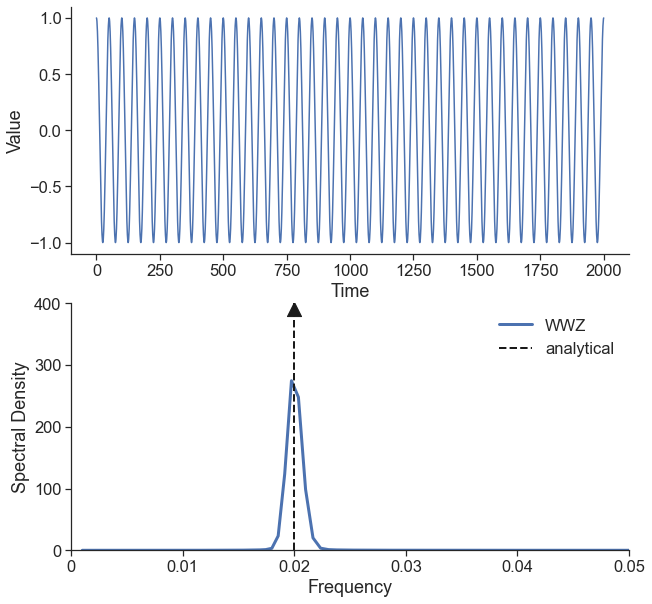

In [112]:
time = np.arange(2001)
f = 1/50
signal = np.cos(2*np.pi*f*time)
series = pd.Series(signal, index=time)

fig, res_psd, ax_spec = run_wwz(series)
ax_spec.set_ylim(0, 400)
ax_spec.axvline(x=0.02, color='k', ls='--', lw=2, label='analytical')
ax_spec.scatter(x=0.02, y=390, marker='^', s=200, color='k')
ax_spec.legend(frameon=False)

In [38]:
%matplotlib inline

{'freq': array([1.25000e-04, 2.50000e-04, 3.75000e-04, ..., 4.99750e-01,
       4.99875e-01, 5.00000e-01]), 'psd': array([9.44251578e-10, 8.51142295e-10, 1.26550907e-09, ...,
       1.53161385e-19, 1.64066158e-19, 1.19615954e-02])}


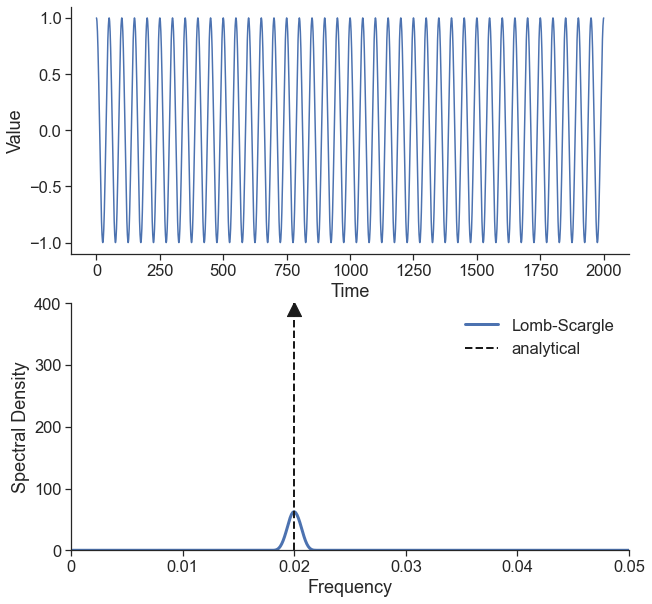

In [117]:
time = np.arange(2001)
f = 1/50
signal = np.cos(2*np.pi*f*time)
series = pd.Series(signal, index=time)

fig, res_psd, ax_spec = run_ls(series,standardize=True)
ax_spec.set_ylim(0, 400)
ax_spec.axvline(x=0.02, color='k', ls='--', lw=2, label='analytical')
ax_spec.scatter(x=0.02, y=390, marker='^', s=200, color='k')
ax_spec.legend(frameon=False)

## Two constant frequencies

Given the idea above, this case is trivial now.

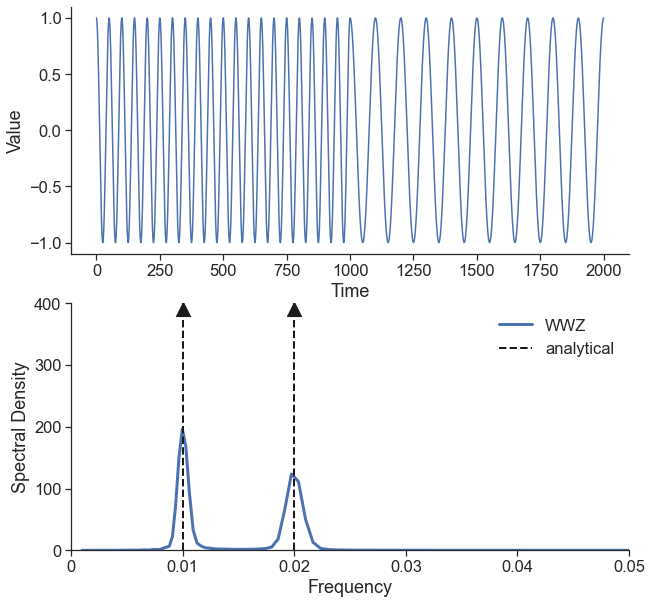

In [125]:
time1 = np.arange(1000)
f1 = 1/50
signal1 = np.cos(2*np.pi*f1*time1)

time2 = np.arange(1000, 2001)
f2 = 1/100
signal2 = np.cos(2*np.pi*f2*time2)

signal = np.concatenate([signal1, signal2])
time = np.concatenate([time1, time2])

series = pd.Series(signal, index=time)

fig, res_psd, ax_spec = run_wwz(series)
ax_spec.set_ylim(0, 400)
ax_spec.axvline(x=0.02, color='k', ls='--', lw=2, label='analytical')
ax_spec.scatter(x=0.02, y=390, marker='^', s=200, color='k')
ax_spec.axvline(x=0.01, color='k', ls='--', lw=2 )
ax_spec.scatter(x=0.01, y=390, marker='^', s=200, color='k')
ax_spec.legend(frameon=False)

{'freq': array([1.25000e-04, 2.50000e-04, 3.75000e-04, ..., 4.99750e-01,
       4.99875e-01, 5.00000e-01]), 'psd': array([2.24787576e-04, 2.42989531e-04, 2.76134071e-04, ...,
       2.49564943e-15, 2.27438797e-15, 2.53464600e-02])}


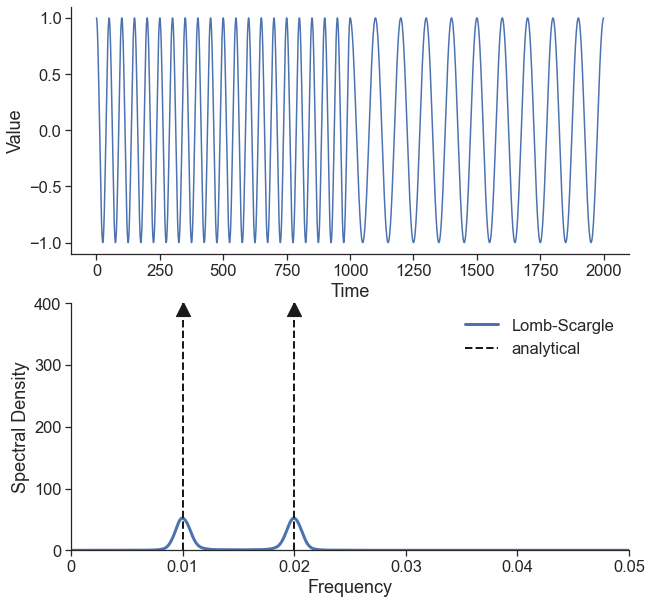

In [126]:
fig, res_psd, ax_spec = run_ls(series,standardize=True)
ax_spec.set_ylim(0, 400)
ax_spec.axvline(x=0.02, color='k', ls='--', lw=2, label='analytical')
ax_spec.scatter(x=0.02, y=390, marker='^', s=200, color='k')
ax_spec.axvline(x=0.01, color='k', ls='--', lw=2 )
ax_spec.scatter(x=0.01, y=390, marker='^', s=200, color='k')
ax_spec.legend(frameon=False)

## Two close constant frequencies

Similarly, also trivial.

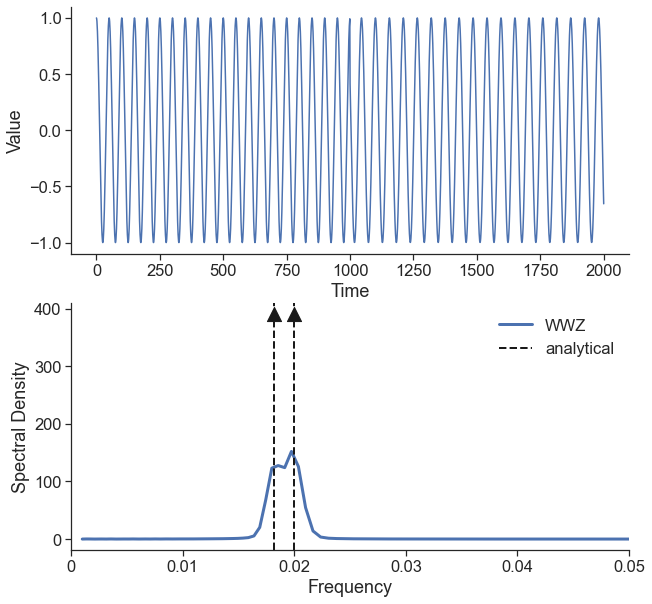

In [127]:
time1 = np.arange(1000)
f1 = 1/50
signal1 = np.cos(2*np.pi*f1*time1)

time2 = np.arange(1000, 2001)
f2 = 1/55
signal2 = np.cos(2*np.pi*f2*time2)

signal = np.concatenate([signal1, signal2])
time = np.concatenate([time1, time2])

series = pd.Series(signal, index=time)


fig, res_psd, ax_spec = run_wwz(series)
#ax_spec.set_ylim(0, 400)
ax_spec.axvline(x=0.02, color='k', ls='--', lw=2, label='analytical')
ax_spec.scatter(x=0.02, y=390, marker='^', s=200, color='k')
ax_spec.axvline(x=1/55, color='k', ls='--', lw=2)
ax_spec.scatter(x=1/55, y=390, marker='^', s=200, color='k')
ax_spec.legend(frameon=False)

{'freq': array([1.25000e-04, 2.50000e-04, 3.75000e-04, ..., 4.99750e-01,
       4.99875e-01, 5.00000e-01]), 'psd': array([2.21239654e-02, 2.57403887e-02, 3.25123499e-02, ...,
       2.89998528e-05, 2.49756868e-05, 2.68217912e-02])}


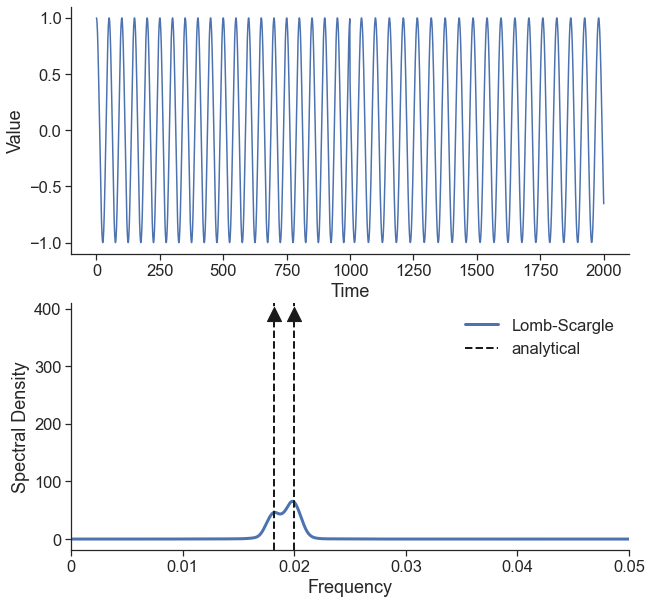

In [128]:
fig, res_psd, ax_spec = run_ls(series,standardize=True)
#ax_spec.set_ylim(0, 400)
ax_spec.axvline(x=0.02, color='k', ls='--', lw=2, label='analytical')
ax_spec.scatter(x=0.02, y=390, marker='^', s=200, color='k')
ax_spec.axvline(x=1/55, color='k', ls='--', lw=2 )
ax_spec.scatter(x=1/55, y=390, marker='^', s=200, color='k')
ax_spec.legend(frameon=False)

## Colored noise

The colored noise is constructed as
$x(t) = \Sigma_{k=1}^m (kf_0)^{-\alpha/2} \sin(\omega_0 t + \phi_k)$, so that the analytical PSD will follow a slope of $\alpha$ in a log-log plot.

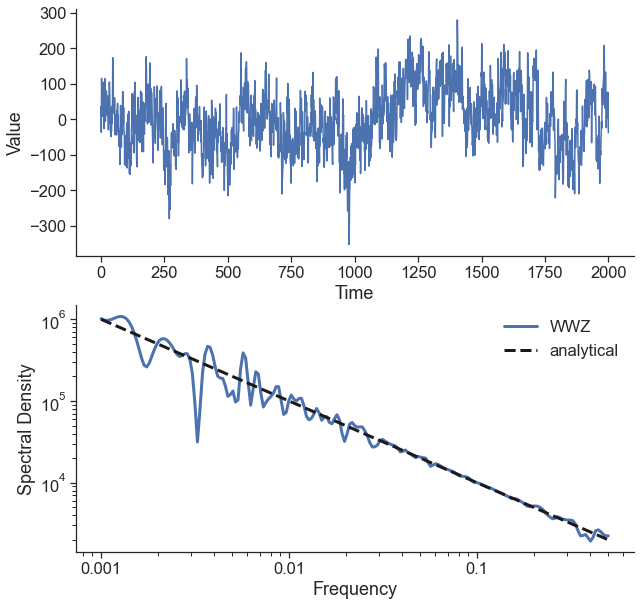

In [129]:
time = np.arange(2001)


signal = colored_noise(1, time, seed=2333)
series = pd.Series(signal, index=time)

fig, res_psd, ax_spec = run_wwz(series,loglog=True)

# analytical PSD
psd_ideal_ref = 0.5*res_psd.freq**(-1)/(1/np.size(time))



ax_spec.plot(res_psd.freq, psd_ideal_ref, color='k', ls='--', lw=3, label='analytical')
ax_spec.legend(frameon=False)

{'freq': array([1.25000e-04, 2.50000e-04, 3.75000e-04, ..., 4.99750e-01,
       4.99875e-01, 5.00000e-01]), 'psd': array([176845.61997481, 194863.84753984, 226253.83041431, ...,
          346.60640301,    308.94970494,    439.2822853 ])}


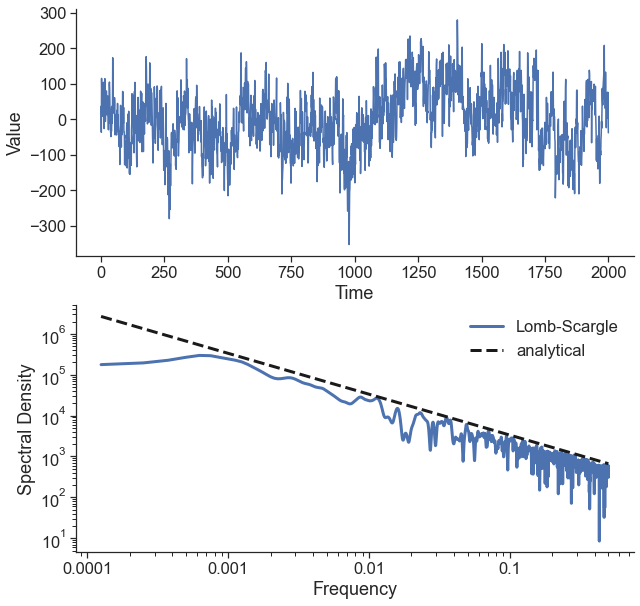

In [147]:
time = np.arange(2001)


signal = colored_noise(1, time, seed=2333)
series = pd.Series(signal, index=time)

fig, res_psd, ax_spec = run_ls(series,loglog=True,standardize=False)

# analytical PSD

psd_ideal_ref = 0.5/3*res_psd['freq']**(-1)/(1/np.size(time))



ax_spec.plot(res_psd['freq'], psd_ideal_ref, color='k', ls='--', lw=3, label='analytical')
ax_spec.legend(frameon=False)

In [138]:
np.mean(psd_ideal_ref/res_psd['psd'])

6.803605892080428

In [139]:
np.median(psd_ideal_ref/res_psd['psd'])

5.121818507798266

## Colored noise with two regiems

Similar situation but two slopes with a break.

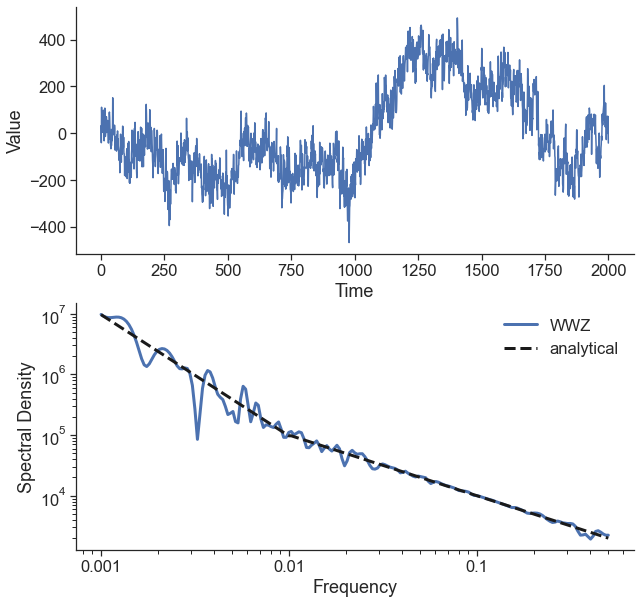

In [149]:
time = np.arange(2001)
signal = colored_noise_2regimes(1, 2, 1/100, time, seed=2333)

series = pd.Series(signal, index=time)

fig, res_psd, ax_spec = run_wwz(series, loglog=True)

psd_ideal_ref1 = 0.5*res_psd.freq**(-1)/(1/np.size(time))

mask1 = res_psd.freq>=1/100
mask2 = res_psd.freq<1/100

# ax_spec.plot(res_psd.freqs[mask1], psd_ideal_ref1[mask1], color='k', ls='--', lw=3, label='analytical')

psd_ideal_ref2 = 0.5*res_psd.freq**(-2)/(1/np.size(time))
s = psd_ideal_ref2[mask2][-1] / psd_ideal_ref1[mask1][0]
psd_ideal_ref2 = psd_ideal_ref2 / s

# ax_spec.plot(res_psd.freqs[mask2], psd_ideal_ref2[mask2], color='k', ls='--', lw=3)

# anaylical PSD
psd_ideal_ref = np.concatenate([psd_ideal_ref2[mask2], psd_ideal_ref1[mask1]])

ax_spec.plot(res_psd.freq, psd_ideal_ref, color='k', ls='--', lw=3, label='analytical')

ax_spec.legend(frameon=False)

{'freq': array([1.25000e-04, 2.50000e-04, 3.75000e-04, ..., 4.99750e-01,
       4.99875e-01, 5.00000e-01]), 'psd': array([2.93038430e+06, 3.22802643e+06, 3.73772139e+06, ...,
       3.46606402e+02, 3.08949704e+02, 2.70876130e+02])}


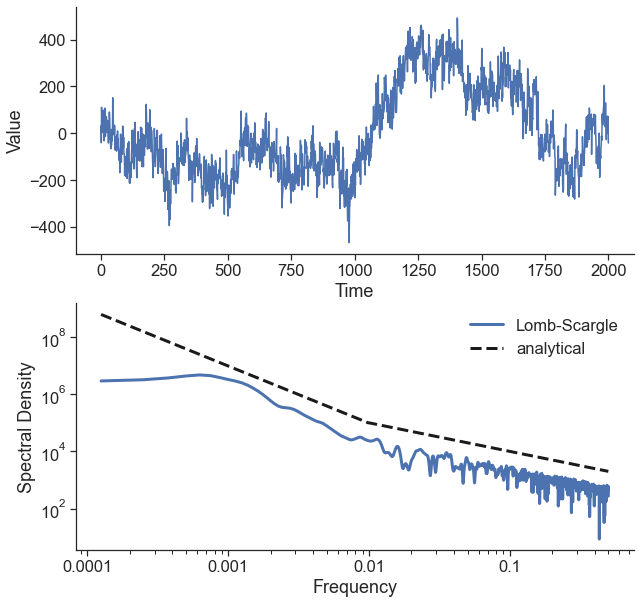

In [150]:
time = np.arange(2001)
signal = colored_noise_2regimes(1, 2, 1/100, time, seed=2333)

series = pd.Series(signal, index=time)

fig, res_psd, ax_spec = run_ls(series, loglog=True)

psd_ideal_ref1 = 0.5*res_psd['freq']**(-1)/(1/np.size(time))

mask1 = res_psd['freq']>=1/100
mask2 = res_psd['freq']<1/100

# ax_spec.plot(res_psd.freqs[mask1], psd_ideal_ref1[mask1], color='k', ls='--', lw=3, label='analytical')

psd_ideal_ref2 = 0.5/3*res_psd['freq']**(-2)/(1/np.size(time))
s = psd_ideal_ref2[mask2][-1] / psd_ideal_ref1[mask1][0]
psd_ideal_ref2 = psd_ideal_ref2 / s

# ax_spec.plot(res_psd.freqs[mask2], psd_ideal_ref2[mask2], color='k', ls='--', lw=3)

# anaylical PSD
psd_ideal_ref = np.concatenate([psd_ideal_ref2[mask2], psd_ideal_ref1[mask1]])

ax_spec.plot(res_psd['freq'], psd_ideal_ref, color='k', ls='--', lw=3, label='analytical')

ax_spec.legend(frameon=False)

## add trend/gap/missing data

If the signal has some linear/nonlinear trend, it essentially means that there is some low-frequency energy that we are not interested in, and therefore, in a perfect scenario, we will detrend perfectly, and hence the analytical spectrum for this case is still that of the original signal, without the impact of the trend.

For missing data and gap cases, the analytical spectrum should still be that of the perfect signal.

## add white noise with different SNRs

Since the summary of the signal and the white noise is linear, and the PSD of white noise is flat, thus the white noise will not affect the peak(s) of the signal with single or two constant frequencies.

The white noise can affect the slope of a colored signal though.
With smaller SNR, which means a larger variance of the white noise, then the mixed signal will become flatter in the log-log plot.

Assume that SNR=1, i.e., the variance of signal is equal to that of the white noise, then due to Parseval's theorem that variance of the signal equals to the integration of the PSD over infinite frequency interval, and that the colored noise is generated over a certain frequency interval from $f_0 = 1/n$ ($n$ being the length of the signal) to $f_{-1} = 1/2$, we have
$$
\int_{1/n}^{1/2} S(f) df = \text{var}(X(t)) = \text{var}(\text{w.n.}) = \int_{1/n}^{1/2} S(f_{\text{w.n.}}) df
$$, which means that the integrated area of the signal in the frequency domain should be equal to that of the white noise.

Due to the property of a log-log plot, adding same amount of the energy at different frequencies to a colored noise will eventually result in a curve, with the lower-ferquency end getting closer to the orignal slope but the higher-frequency end becoming flatter.
Physically speaking, the white noise makes the higher-frequency signal more difficult to be detected.

To get the analytical PSD in this case, we will first calculate the energy level of the white noise based on SNR and Parseval's theorem, and then add that part to the analytical PSD of the colored noise.
Other cases can be handled in a similar way.

{'freq': array([1.25000e-04, 2.50000e-04, 3.75000e-04, ..., 4.99750e-01,
       4.99875e-01, 5.00000e-01]), 'psd': array([184193.41615006, 202898.78212709, 235416.35719829, ...,
         1228.69396365,   1086.33384708,   1881.19742485])}


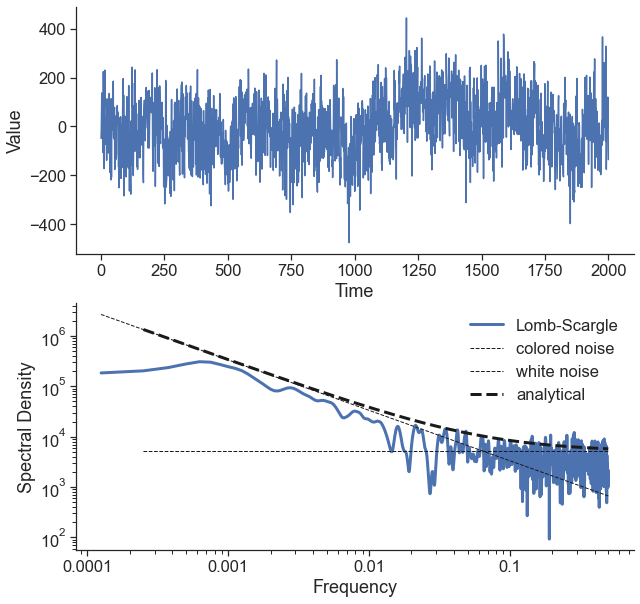

In [151]:
np.random.seed(2333)
time = np.arange(2001)
signal = colored_noise(1, time, seed=2333)
SNR = 1
sig_var = np.var(signal)
noise_var = sig_var / SNR
white_noise = np.random.normal(0, np.sqrt(noise_var), size=np.size(signal))
signal_noise = signal + white_noise
series = pd.Series(signal_noise, index=time)

loglog=True
detrend=False
    
fig, res_psd, ax_spec = run_ls(series, loglog=loglog, detrend=detrend)

# anaylical PSD for colored noise
psd_ideal_ref = 0.5/3*res_psd['freq']**(-1)/(1/np.size(time))
ax_spec.plot(res_psd['freq'], psd_ideal_ref, color='k', ls='--', lw=1, label='colored noise')

# anaylical PSD for white noise
area = np.trapz(psd_ideal_ref[1:], x=res_psd['freq'][1:]) # the 1st is inf due to zero-frequency
psd_wn = np.empty(np.size(res_psd['freq'][1:]))
psd_wn_value = area / (1/2-1/np.size(time))
psd_wn[:] = psd_wn_value
ax_spec.plot(res_psd['freq'][1:], psd_wn, color='k', ls='--', lw=1, label='white noise')

# anaylical PSD for colored noise
psd_ana = psd_ideal_ref[1:] + psd_wn
ax_spec.plot(res_psd['freq'][1:], psd_ana, color='k', ls='--', lw=3, label='analytical')
ax_spec.legend(frameon=False)

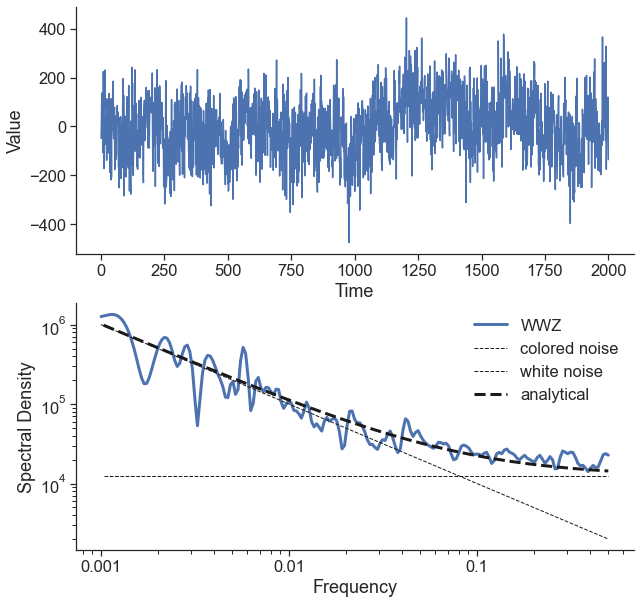

In [85]:
np.random.seed(2333)
time = np.arange(2001)
signal = colored_noise(1, time, seed=2333)
SNR = 1
sig_var = np.var(signal)
noise_var = sig_var / SNR
white_noise = np.random.normal(0, np.sqrt(noise_var), size=np.size(signal))
signal_noise = signal + white_noise
series = pd.Series(signal_noise, index=time)

loglog=True
detrend=False
    
fig, res_psd, ax_spec = run_wwz(series, loglog=loglog, detrend=detrend)

# anaylical PSD for colored noise
psd_ideal_ref = 0.5*res_psd.freq**(-1)/(1/np.size(time))
ax_spec.plot(res_psd.freq, psd_ideal_ref, color='k', ls='--', lw=1, label='colored noise')

# anaylical PSD for white noise
area = np.trapz(psd_ideal_ref[1:], x=res_psd.freq[1:]) # the 1st is inf due to zero-frequency
psd_wn = np.empty(np.size(res_psd.freq[1:]))
psd_wn_value = area / (1/2-1/np.size(time))
psd_wn[:] = psd_wn_value
ax_spec.plot(res_psd.freq[1:], psd_wn, color='k', ls='--', lw=1, label='white noise')

# anaylical PSD for colored noise
psd_ana = psd_ideal_ref[1:] + psd_wn
ax_spec.plot(res_psd.freq[1:], psd_ana, color='k', ls='--', lw=3, label='analytical')
ax_spec.legend(frameon=False)